# Solver-in-the-Loop [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tumaer/jax-sph/blob/main/notebooks/iclr24_sitl.ipynb)

This notebook contains instructions on the Solver-in-the-Loop results in the ICLR 2024 AI4DiffEq workshop paper. We cover a) dataset generation, b) training and inference, and c) plots.

 This file relies on [LagrangeBench](https://github.com/tumaer/lagrangebench), which can be installed by `pip install lagrangebench==0.2.0 --extra-index-url=https://download.pytorch.org/whl/cpu`. For more information on the training and inference setup, visit the LagrangeBench website.

## Dataset generation

Our reverse Poiseuille flow dataset was generated following the RPF2D LagrangeBench dataset, but subsampled at every 20th SPH step. The original script can be found on the [LagrangeBench GitHub](https://github.com/tumaer/lagrangebench/tree/main/data_gen/lagrangebench_data). We modified this script to subsample every 20th rather than every 100th step, leading to the following bash script. We first generate a dataset of every 10th SPH frame and then slice every 2nd frame out. Also, we copy the `dataset_gen.py` file from LagrangeBench and use it to process the raw simulation data to a dataset.

```bash
# relax system by quicker break symmetries in the simulation
python main.py config=cases/rpf.yaml case.dim=2 case.dx=0.025 case.mode=rlx solver.tvf=1.0 case.r0_noise_factor=0.1 io.data_path=data_relaxed/ seed=0
# run a simulation and record every 10th frame
python main.py config=cases/rpf.yaml case.dim=2 case.dx=0.025 solver.dt=0.0005 solver.t_end=1050 case.state0_path=data_relaxed/rpf_2_0.025_0.h5 io.data_path=data_raw/2D_RPF_3200_10kevery10/
# raw simulation trajectory to dataset
python dataset_gen.py --src_dir=data_raw/2D_RPF_3200_10kevery10/ --dst_dir=dataset/2D_RPF_3200_10kevery20/ --split=2_1_1 --skip_first_n_frames=9980 --slice_every_nth_frame=2
```

## Training and Inference

As described in the ICLR '24 paper, we have three forward models:
1. Solver doing three intermediate integration steps, termed `Solver only (L=3)`.
2. The baseline GNS model without intermediate steps, termed `Learned only (L=1)`.
3. Solver-in-the-Loop combining GNS and SPH for 3 iterations, termed `SitL (L=3)`.

To set up the environment, we first need to install LagrangeBench. For more details, check the instructions [here](https://github.com/tumaer/lagrangebench/tree/main?tab=readme-ov-file#installation). Our results are based on running the following:

In [ ]:
! pip install lagrangebench==0.2.0 --extra-index-url=https://download.pytorch.org/whl/cpu
! pip install -U "jax[cuda12]"

## Training

Here are the configurations that we trained. We recommend training from the terminal as training takes multiple hours to days.

In [ ]:
# 2. Learned only (L=1) - takes around 10h
! python iclr24_sitl.py \
    model.name=gns train.noise_std=0.0003 train.optimizer.lr_start=0.001
# 3. SitL (L=3) - takes around a day
! python iclr24_sitl.py

## Inference

Run a rollout of 500 steps (`eval.num_rollout_steps=20` + `eval.infer.n_extrap_steps=480`)

In [ ]:
# 1. Solver only (L=3)
! python iclr24_sitl.py \
    model.gnn_prefactor=0.0 mode=infer eval.infer.n_extrap_steps=480 eval.test=true
# 2. Learned only (L=1)
! python iclr24_sitl.py \
    model.name=gns train.noise_std=0.0003 train.optimizer.lr_start=0.001 \
    mode=infer eval.infer.n_extrap_steps=480 eval.test=true
# 3. SitL (L=3)
! python iclr24_sitl.py \
    mode=infer eval.infer.n_extrap_steps=480 eval.test=true

## Plots

Run the cells below to reproduce the plots from the ICLR '23 workshop paper.

In [1]:
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["JAX_PLATFORMS"] = "cpu"

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from jax import vmap

from jax_sph.jax_md import space

In [2]:
root = os.getcwd()
with open("../datasets/2D_RPF_3200_10kevery20/metadata.json", "r") as f:
    metadata = json.loads(f.read())

bounds = np.array(metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]
displacement_fn, _ = space.periodic(side=jnp.array(box))
displacement_fn_vmap = vmap(displacement_fn, in_axes=(0, 0))

data = {}
for suffix in ["solver", "gns", "sitl"]:
    data[suffix] = {}
    for step in [0, 250, 500]:
        pv_dataset = pv.read(
            os.path.join("../rollouts", suffix, f"rollout_0_{step}.vtk")
        )
        pv_dataset1 = pv.read(
            os.path.join("../rollouts", suffix, f"rollout_0_{step + 1}.vtk")
        )
        r = np.array(pv_dataset.points)
        r1 = np.array(pv_dataset1.points)
        v = displacement_fn_vmap(r1[:, :2], r[:, :2])
        v = np.sqrt(v[:, 0] ** 2 + v[:, 1] ** 2)
        v /= metadata["dt"] * metadata["write_every"]
        data[suffix][step] = {"r": r, "v": v}

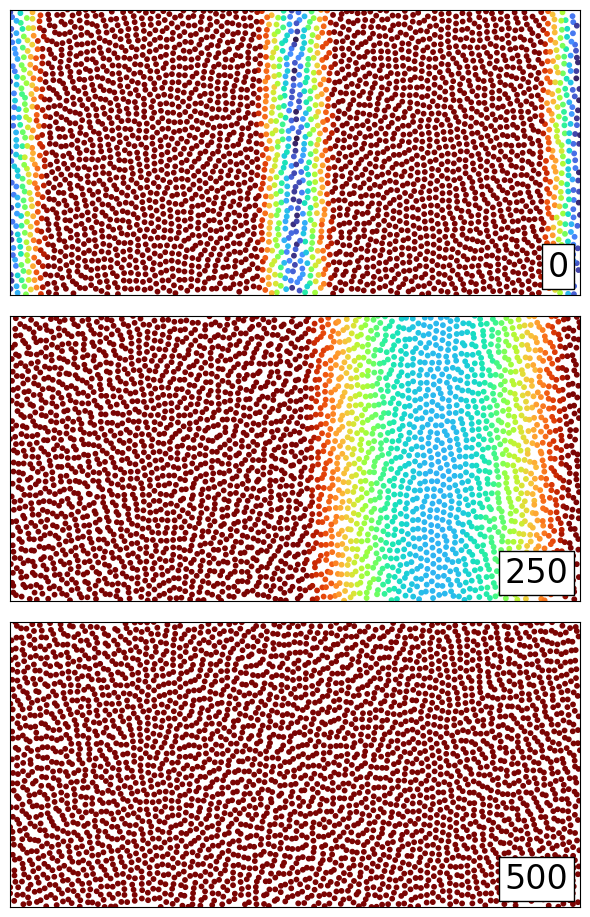

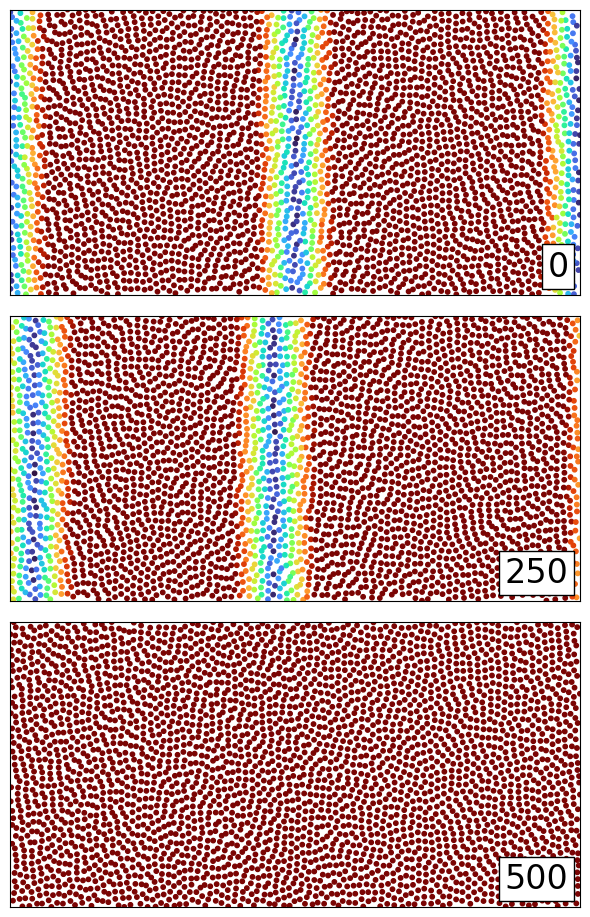

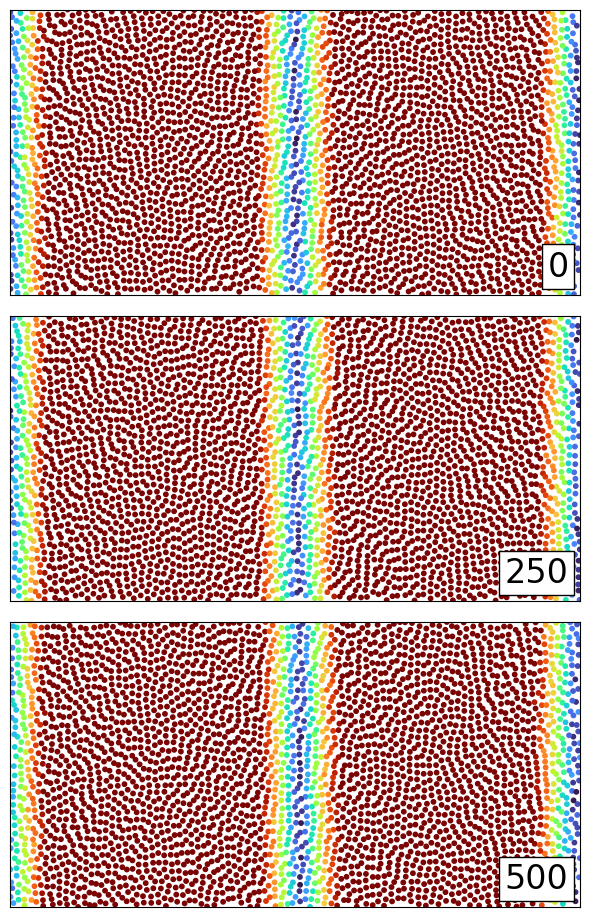

In [3]:
for suffix in data:
    fig, axs = plt.subplots(3, 1, figsize=(6, 12))
    for i, step in enumerate(data[suffix]):
        r = data[suffix][step]["r"]
        v = data[suffix][step]["v"]
        ax = axs[i]
        ax.scatter(r[:, 1], r[:, 0], vmin=0.0, vmax=1.0, c=v, cmap="turbo", s=10)
        ax.set_xlim(metadata["bounds"][1])
        ax.set_ylim(metadata["bounds"][0])
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(
            0.98,
            0.04,
            f"{step}",
            color="black",
            bbox=dict(facecolor="white", edgecolor="black"),
            ha="right",
            va="bottom",
            transform=ax.transAxes,
            fontsize=24,
        )
        ax.grid()
        # add colorbar underneath the image
        fig.tight_layout()
        fig.subplots_adjust(bottom=0.2)

    fig.savefig(f"sitl_{suffix}.pdf", bbox_inches="tight")